# Init

In [45]:
## install required packages
!pip install swig
!pip install wrds
!pip install pyportfolioopt
## install finrl library
!pip install setuptools==65.5.0
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached setuptools-65.5.0-py3-none-any.whl (1.2 MB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.8.0
    Uninstalling setuptools-67.8.0:
      Successfully uninstalled setuptools-67.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cvxpy 1.3.1 requires setuptools>65.5.1, but you have setuptools 65.5.0 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-wmb7ran2
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-wmb7ran2
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit d9f0af8021e0995dec71043ed517af954e3f1a4d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-2yyuupoj/elegantrl_90317170533e40cc98219b8b1bc2c8fc
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-2yyuupoj/elegantrl_90317170533e40cc98219b8b1bc2c8fc
  Resolved https://github.com/AI4Finance-Foundation/ElegantRL.git to commit 0c019eec035391dbe7aca1464ed6a0067e5

In [46]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.meta.env_portfolio_allocation.env_portfolio import StockPortfolioEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL")

import itertools

In [47]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

In [48]:
import sys
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import copy
from typing import Any, Dict, List, Optional, Tuple, Type, TypeVar, Union
import torch as th
from torch.nn import functional as F
import yfinance as yf
from itertools import count
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from pandas_datareader import data as pdr
import numpy as np
import random
import math
import time
import gymnasium as gym
from scipy.special import softmax
from gymnasium.utils import seeding
from gymnasium import spaces
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt import objective_functions
from pypfopt.efficient_frontier import EfficientFrontier
import torch
from collections import namedtuple, deque
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Dataset

In [49]:
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2021-10-01'
TRADE_START_DATE = '2021-10-01'
TRADE_END_DATE = '2023-03-01'

In [50]:
df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [51]:
df.sort_values(['date','tic'],ignore_index=True).head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,open,high,low,close,volume,tic,day
0,2010-01-04,7.622500,7.660714,7.585000,6.496294,493729600,AAPL,0
1,2010-01-04,56.630001,57.869999,56.560001,42.488064,5277400,AMGN,0
2,2010-01-04,40.810001,41.099998,40.389999,33.551670,6894300,AXP,0
3,2010-01-04,55.720001,56.389999,54.799999,43.777538,6186700,BA,0
4,2010-01-04,57.650002,59.189999,57.509998,40.934715,7325600,CAT,0


## Preprocess

In [52]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3310, 8)
Successfully added vix
Successfully added turbulence index


In [53]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [54]:
mvo_df = processed_full.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [55]:
len(processed),len(processed_full),len(df)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(95990, 95990, 97013)

In [56]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

85753
10237


In [57]:
train.tail()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
2956,2021-09-30,UNH,401.489990,403.489990,390.459991,383.180176,3779900.0,3.0,-4.349259,419.212256,386.863779,40.895399,-222.938219,41.980385,405.947465,405.438423,23.139999,24.872231
2956,2021-09-30,V,227.580002,228.789993,222.630005,219.829178,7128500.0,3.0,-1.535733,228.194397,216.108271,44.078992,-54.593439,19.569853,224.339920,231.029016,23.139999,24.872231
2956,2021-09-30,VZ,54.500000,54.509998,54.000000,49.011547,18736600.0,3.0,-0.233667,50.131164,48.744040,41.824901,-102.799207,21.682953,49.605026,50.130593,23.139999,24.872231
2956,2021-09-30,WBA,48.790001,48.930000,46.919998,43.298756,6449400.0,3.0,-0.249740,47.804740,42.944107,44.613731,-107.260975,0.941150,45.199112,44.185760,23.139999,24.872231
2956,2021-09-30,WMT,140.639999,141.729996,139.250000,135.599670,7485900.0,3.0,-1.548948,145.602003,135.119863,40.165792,-151.532349,45.466733,141.806628,140.712199,23.139999,24.872231


In [58]:
trade.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2021-10-01,AAPL,141.899994,142.919998,139.110001,141.208954,94639600.0,4.0,-1.701136,155.168227,136.942764,46.927740,-142.198230,41.749873,146.968512,146.067378,21.1,120.122738
0,2021-10-01,AMGN,213.589996,214.610001,210.800003,201.940552,2629400.0,4.0,-3.068378,210.779252,197.515973,40.408599,-96.817065,36.189244,206.532158,215.074072,21.1,120.122738
0,2021-10-01,AXP,168.500000,175.119995,168.479996,170.065353,3956000.0,4.0,2.273327,174.218854,149.232895,56.265091,117.538413,15.667511,161.215665,163.458887,21.1,120.122738
0,2021-10-01,BA,222.850006,226.720001,220.600006,226.000000,9113600.0,4.0,0.730320,226.909442,205.727561,51.614047,116.649440,2.027170,217.175334,221.968500,21.1,120.122738
0,2021-10-01,CAT,192.899994,195.869995,191.240005,186.913452,3695500.0,4.0,-3.620669,204.625195,180.453254,41.999446,-112.106509,36.203176,195.930334,199.439525,21.1,120.122738


In [59]:
INDICATORS

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [60]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [61]:
train

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2010-01-04,AAPL,7.622500,7.660714,7.585000,6.496294,493729600.0,0.0,0.000000,6.517795,6.486025,100.000000,66.666667,100.000000,6.496294,6.496294,20.040001,0.000000
0,2010-01-04,AMGN,56.630001,57.869999,56.560001,42.488064,5277400.0,0.0,0.000000,6.517795,6.486025,100.000000,66.666667,100.000000,42.488064,42.488064,20.040001,0.000000
0,2010-01-04,AXP,40.810001,41.099998,40.389999,33.551670,6894300.0,0.0,0.000000,6.517795,6.486025,100.000000,66.666667,100.000000,33.551670,33.551670,20.040001,0.000000
0,2010-01-04,BA,55.720001,56.389999,54.799999,43.777538,6186700.0,0.0,0.000000,6.517795,6.486025,100.000000,66.666667,100.000000,43.777538,43.777538,20.040001,0.000000
0,2010-01-04,CAT,57.650002,59.189999,57.509998,40.934715,7325600.0,0.0,0.000000,6.517795,6.486025,100.000000,66.666667,100.000000,40.934715,40.934715,20.040001,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2956,2021-09-30,UNH,401.489990,403.489990,390.459991,383.180176,3779900.0,3.0,-4.349259,419.212256,386.863779,40.895399,-222.938219,41.980385,405.947465,405.438423,23.139999,24.872231
2956,2021-09-30,V,227.580002,228.789993,222.630005,219.829178,7128500.0,3.0,-1.535733,228.194397,216.108271,44.078992,-54.593439,19.569853,224.339920,231.029016,23.139999,24.872231
2956,2021-09-30,VZ,54.500000,54.509998,54.000000,49.011547,18736600.0,3.0,-0.233667,50.131164,48.744040,41.824901,-102.799207,21.682953,49.605026,50.130593,23.139999,24.872231
2956,2021-09-30,WBA,48.790001,48.930000,46.919998,43.298756,6449400.0,3.0,-0.249740,47.804740,42.944107,44.613731,-107.260975,0.941150,45.199112,44.185760,23.139999,24.872231


# Environment

In [62]:
x_train = []
x_trade = []

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [63]:
for d in train.date.unique():
  x_train.append(train[train.date == d].iloc[:,5:].to_numpy())
for d in trade.date.unique():
  x_trade.append(trade[trade.date==d].iloc[:,5:].to_numpy())

In [64]:
x_train = np.array(x_train)
x_trade = np.array(x_trade)

In [65]:
x_train.shape,x_trade.shape

((2957, 29, 13), (353, 29, 13))

vars
* window_size
* data
* day
* current_step
* action_space = 1D (0 to 1) 
* observation_space = 3D (window_size, stock_index, closing and other paramters)
* portfolio_value = 1  

In [66]:
class PortfolioEnv(gym.Env):
    def __init__(self, config):
        super(PortfolioEnv, self).__init__()
        self.data = config.get('stock_data')
        self.window_size = config.get('window_size')

        self.day = self.window_size
        self.current_step = self.window_size
        # Define the action and observation space
        self.action_space = spaces.Box(low=-20, high=20, shape=(self.data.shape[1],), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.window_size, self.data.shape[1], self.data.shape[2]+1), dtype=np.float32)

        self.portfolio_value = 1e6
        self.balance = 1e6

        self.weights = np.zeros(self.data.shape[1])
        self.weights.fill(1/self.data.shape[1])
        self.memory = []
        self.weights_memory = []
        # Initialize the state
        self.reset()

    def step(self, action):
        # Execute one step of the environment
        action = softmax(action) # Clip action values to [0, 1]
        self.weights = np.array(action).reshape(-1)
        self.weights_memory.append(self.weights)

        self.portfolio_value = self.balance
        self.memory.append(self.portfolio_value)
        
        # Update the state
        self.observation = self.get_observation()
        reward = 0
        for i in range(self.data.shape[1]):
          reward += ((self.data[self.day+1,i,0]-self.data[self.day,i,0])/self.data[self.day,i,0])*self.weights[i]*self.balance
        
        self.balance += reward
        # Move to the next time step
        self.current_step += 1
        self.day += 1
        # Calculate the reward and done flag
        done = self.day >= self.data.shape[0] - 1
        return self.observation, (reward/1e6), done, {}

    def reset(self, *, seed=None, options=None):
        # Reset the environment to the initial state
        self.current_step = self.window_size
        self.day = self.window_size
        self.portfolio_value = 1e6
        self.balance = 1e6
        self.weights = np.zeros(self.data.shape[1])
        self.weights.fill(1/self.data.shape[1])
        self.memory = []
        self.weights_memory = []
        # Initialize the state
        self.observation = self.get_observation()

        return self.observation, {}

    def get_observation(self):
        state = np.zeros(self.observation_space.shape)
        state[:,:,:-1] = np.array(self.data[self.day-self.window_size:self.day])
        state[:,:,-1] = np.repeat(self.weights.reshape(1,-1),self.observation_space.shape[0],axis=0)
        return state

# Transformer Policy

In [ ]:
from functools import reduce

In [ ]:
from tensorflow.python.ops.math_ops import Prod
import torch
from torch import nn
from ray.rllib.models.torch.torch_modelv2 import TorchModelV2

class TransformerModel(TorchModelV2,nn.Module):

    def __init__(self,  obs_space, action_space, num_outputs, model_config, name):
        super().__init__( obs_space, action_space, num_outputs, model_config, name)
        nn.Module.__init__(self)
        # Define the transformer encoder
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=406, nhead=7, batch_first = True)
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=6)

        self.action_shape = action_space.shape
        self.obs_shape = obs_space.shape
        self.prod = reduce(lambda a, b: a * b, self.obs_shape)
        # Define the policy head.
        self.policy_head = torch.nn.Linear(self.prod, 2*self.action_shape[0])
        self.critic_head = torch.nn.Linear(self.prod, 1)

    def forward(self, input_dict, state, seq_lens):
        obs = input_dict['obs']
        batch,time,stock,features = obs.shape
        obs_t = obs.view(batch,time,stock*features)
        network_output = self.encoder(obs_t)
        network_output = network_output.view(batch,-1)
        value = self.critic_head(network_output)
        self._value = value.reshape(-1)
        logits = self.policy_head(network_output)
        return logits, state

    def value_function(self):
        return self._value
    

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <
/usr/local/lib/python3.10/dist-packages/google/rpc/__init__.py:20: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.rpc')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  pkg_resources.declare_namespace(__name__)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:2349: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespac

#PPO CONFIG

In [ ]:
env = PortfolioEnv({
        'stock_data' : x_train,
        'window_size' : 7
        })

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
torch.cuda.is_available()

True

In [ ]:
import ray
from ray.tune.registry import register_env
from ray.rllib.algorithms.ppo import PPOConfig

In [ ]:
!npm install -g localtunnel
!curl ipecho.net/plain

35.198.207.196

In [ ]:
!lt --port 8265

your url is: https://quick-keys-sort.loca.lt
(autoscaler +15m11s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +15m46s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +16m21s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +16m56s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or ad

In [ ]:
# Start up Ray. This must be done before we instantiate any RL agents.
ray.init(num_gpus=1, ignore_reinit_error=True, log_to_driver=False)

2023-06-03 08:31:35,686	INFO worker.py:1616 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.10.11
Ray version:,2.4.0
Dashboard:,http://127.0.0.1:8265


In [ ]:
config = (  # 1. Configure the algorithm,
    PPOConfig()
    .environment(
        env = PortfolioEnv,
        env_config={
        'stock_data' : x_train,
        'window_size' : 7
        },
      )
    .rollouts(num_rollout_workers=1)
    .training(
            model={
                "custom_model": TransformerModel,
                "vf_share_layers": True,
            }
        )
    .evaluation(evaluation_num_workers=1)
    .framework('torch')
)

In [ ]:
algo = config.build()  # 2. build the algorithm,

for _ in range(3):
    print(algo.train())  # 3. train it,

algo.evaluate()  # 4. and evaluate it.

In [ ]:
algo.evaluate()

{'evaluation': {'episode_reward_max': 5.255761045345548,
  'episode_reward_min': 3.504545335181302,
  'episode_reward_mean': 4.41033168504211,
  'episode_len_mean': 2949.0,
  'episode_media': {},
  'episodes_this_iter': 10,
  'policy_reward_min': {},
  'policy_reward_max': {},
  'policy_reward_mean': {},
  'custom_metrics': {},
  'hist_stats': {'episode_reward': [5.255761045345548,
    4.636744176381536,
    4.759678556375781,
    3.9344695981968005,
    4.6679771687221345,
    3.7734612575827287,
    4.344291746654184,
    3.504545335181302,
    4.664006645698804,
    4.562381320282287],
   'episode_lengths': [2949,
    2949,
    2949,
    2949,
    2949,
    2949,
    2949,
    2949,
    2949,
    2949]},
  'sampler_perf': {'mean_raw_obs_processing_ms': 0.5231618291060577,
   'mean_inference_ms': 21.982418791913318,
   'mean_action_processing_ms': 0.3912028168165439,
   'mean_env_wait_ms': 0.24790747847765165,
   'mean_env_render_ms': 0.0},
  'num_faulty_episodes': 0,
  'connector_me

In [73]:
algo.compute_single_action(env.observation_space.sample())

array([-15.7765   , -20.       ,  20.       ,  20.       ,  -1.6416016,
        -6.0046844, -20.       ,  20.       ,   3.201332 , -20.       ,
       -20.       ,  -3.7966957,  20.       , -19.158335 ,  15.436802 ,
         1.0629044,  -9.675524 ,  20.       ,  14.0224495,  17.48486  ,
         8.354673 , -20.       ,  20.       ,  15.933235 ,   5.823288 ,
       -20.       ,  20.       ,  -2.5916672,  11.839844 ], dtype=float32)

#BackTest

In [76]:
trade_env = PortfolioEnv({
        'stock_data' : x_trade,
        'window_size' : 7
        })

In [77]:
portfolio_values = []
portfolio_actions = []

In [78]:
model = algo

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [97]:
obs = trade_env.reset()[0]
while True:
    action = model.compute_single_action(obs)
    obs, rewards, dones, info = trade_env.step(action)
    if(dones==True):
      portfolio_values = trade_env.memory
      portfolio_actions = trade_env.weights_memory
      break

In [98]:
portfolio_values = np.array(portfolio_values)

In [99]:
import seaborn as sns
sns.set_theme(style="darkgrid")

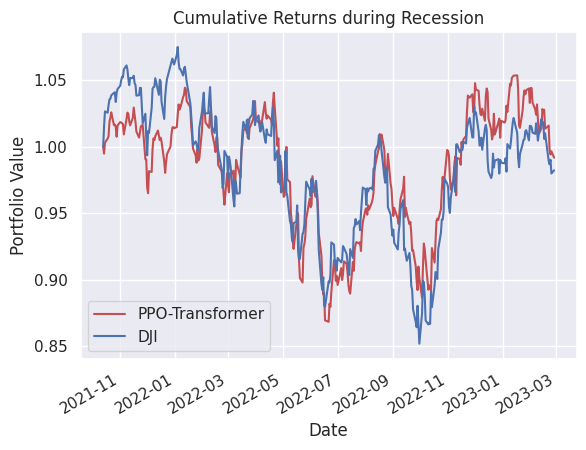

In [100]:
x = np.asarray(trade.date.unique()[8:], dtype='datetime64[s]') 
plt.plot(x,portfolio_values/portfolio_values[0],c='r',label='PPO-Transformer')
plt.plot(x,x_trade[8:,:,0].sum(axis=1)/x_trade[8:,:,0].sum(axis=1)[0],label='DJI')
plt.gcf().autofmt_xdate()
plt.legend()
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('Cumulative Returns during Recession')
plt.show()

# Transformer Policy

# Transformer DDPG